# Variational AutoEncoders

We will implement a Variational AutoEncoder and run it on face data.

Once you are satisfied with your implementation, send hw2.ipynb to **vjojic+hw2+comp790@cs.unc.edu**.

Save your python notebook frequently.

All you have to do is replace ```...``` with appropriate code.

The deadline for this homework assignment is 4/4/2017 23:59PM EST.
$ %These are LaTeX definitions used below to save space
\newcommand{\zz}{\mathbf{z}} \newcommand{\xx}{\mathbf{x}} 
\newcommand{\hh}{\mathbf{h}} \newcommand{\bb}{\mathbf{b}}
\newcommand{\dec}{\textrm{dec}} \newcommand{\enc}{\textrm{enc}} 
\newcommand{\rec}{\textrm{rec}}
\newcommand{\relu}{\textrm{ReLU}} \newcommand{\mmu}{\boldsymbol{\mu}}
\newcommand{\ssigma}{\boldsymbol{\sigma}} \newcommand{\eepsilon}{\boldsymbol{\epsilon}}
\newcommand{\KL}{\textrm{KL}}
$

## Load data
First we will look at the data. 

In [9]:
from os import listdir
from os.path import isfile, join
def getFiles(mypath):
    onlyfiles = [(mypath+"/"+f) for f in listdir(mypath) if isfile(join(mypath, f))]
    return onlyfiles

Each row of data matrix is an image consisting of 20*28=560 pixels.
Some images from the dataset
3399
3399
rgb/seq0_0000_2.ppm
480
[[ 0.22712843]
 [ 0.11083705]
 [ 0.12519997]
 ..., 
 [ 0.00059954]
 [ 0.        ]
 [ 0.09517209]]


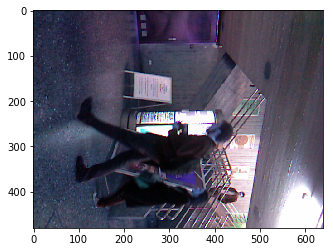

In [3]:
import numpy as np
import matplotlib.pyplot as pyplot
import cv2
%matplotlib inline 
#faces = np.load('freyfaces.npy',encoding='latin1')
#faces = np.load('freyfaces.npy')
hog = cv2.HOGDescriptor()
hog.setSVMDetector( cv2.HOGDescriptor_getDefaultPeopleDetector() )
#print("Shape of data (samples x dimensions):",faces.shape)
print("Each row of data matrix is an image consisting of 20*28=560 pixels.")
print("Some images from the dataset")

rgb_img = getFiles("rgb")
rgb_img.sort()
print(len(rgb_img))
depth_img = getFiles("depth")
depth_img.sort()
print(len(depth_img))
print(rgb_img[2])
img = cv2.imread(rgb_img[10])
#print(img)
pyplot.imshow(img)
#help(hog)
print(len(img))

grad = hog.computeGradient(img)
#print(grad)
desc = hog.compute(img)
#print(len(grad[1]))
print(desc)
   # im.reshape(im.shape[0], im.shape[1]), cmap=plt.cm.Greys)
    
#show_examples(faces[0:1500:50,:])


In [4]:
from sklearn import svm
X = [[0, 0], [1, 1]]
y = [0, 1]
clf = svm.LinearSVC()
clf.fit(X, y) 
a = clf.predict([[2., 2.]])
print(a)

[1]


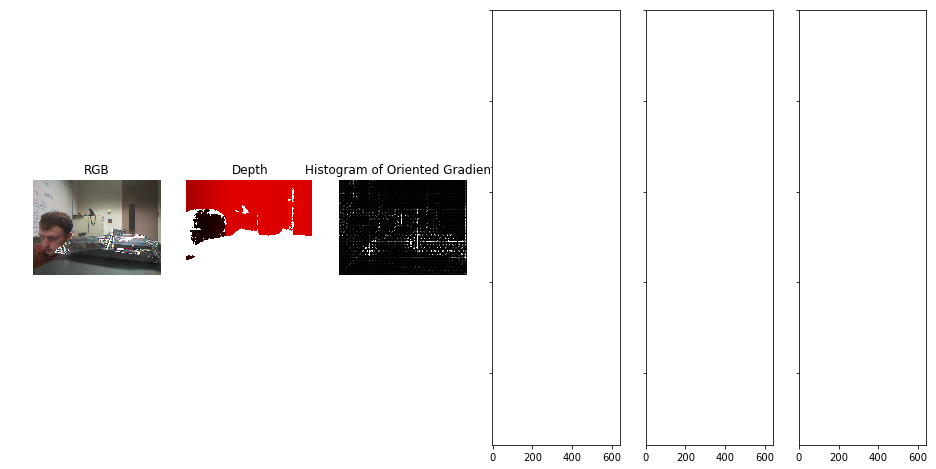

In [55]:
import matplotlib.pyplot as plt

from skimage.feature import hog as hog_feat
from skimage import data, color, exposure


from freenect import sync_get_depth as get_depth, sync_get_video as get_video

(image_color,_) = get_video()

(image_depth,_) = get_depth()

image = color.rgb2gray(image_color)

rows,cols = image.shape

rot = image

fd, hog_image = hog_feat(rot, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)



#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(1, 6, figsize=(16, 8), sharex=True, sharey=True)


rows,cols = image.shape

#M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
#rot = cv2.warpAffine(img,M,(cols,rows))

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

#hog_rot = cv2.warpAffine(hog_image_rescaled,M,(cols,rows))
#rot = cv2.warpAffine(image_color,M,(cols,rows))
rot = image_color

ax1.axis('off')
ax1.imshow(rot) #, cmap=plt.cm.gray)
ax1.set_title('RGB')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(image_depth,cmap=plt.cm.hot)
ax2.set_title('Depth')
ax2.set_adjustable('box-forced')


ax3.axis('off')
ax3.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax3.set_title('Histogram of Oriented Gradients')
ax3.set_adjustable('box-forced')
plt.show()

ax4.set_title('Prediction')
Z = np.random.rand(6, 10)

ax4.pcolor(Z)

In [11]:
track_a = getFiles("track_annotations")
track_a.sort()
dicts = []
for a in track_a:
    b = a.split('/')
    c = b[1].split('_')
    d = c[1].split('.')
    g = d[0]

    f = open(a)
    text = f.read()
    lines = text.splitlines()
    for line in lines:
        data = line.split()
        if (data[0]!='#'):#comment line == bad
            dicto = {'IMAGE_NAME_ID':data[0],
                 'X_tl_dpt':data[2],'Y_tl_dpt':data[3],
                 'WDT_dpt':data[4],'HGT_dpt':data[5],
                 'X_tl_rgb':data[6], 'Y_tl_rgb':data[7],
                 'WDT_rgb':data[8], 'HGT_rgb':data[9],
                 'VSB':data[10], 'TRACK':g
                 }
            dicto2 = {data[0]:dicto}
            dicts.append(dicto2)

In [12]:
print len(dicts)

4498


In [13]:
def fileInDicts(f):
    fileName = f.split('/')[1]
    fileName = fileName.split('.')[0]
    b = any(fileName in x for x in dicts)
    return b

In [14]:
winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 5.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

NameError: name 'cv2' is not defined

(480, 640, 3)
(18900, 1)


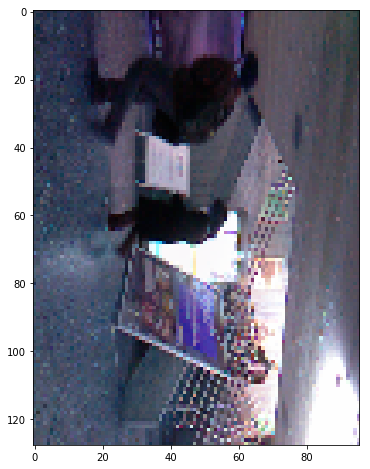

In [9]:
import cv2
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 8), sharex=True, sharey=True)
hog = cv2.HOGDescriptor()
img = cv2.imread(rgb_img[55])
#ax1.imshow(img)
i2 = cv2.resize(img, (96, 128)) 
print img.shape
ax1.imshow(i2)
scalen = 0

#resize(img_iri, img_ir, (640,480),scalen, scalen, INTER_LANCZOS4);
#cv2.imshow(i2)
d = hog.compute(i2)
print d.shape
#print i2.type

In [10]:
img = cv2.imread(rgb_img[55])

resized_image = cv2.resize(img, (96, 128)) 
d = hog.compute(resized_image)
print d.shape
print d
X = np.zeros(shape=(2501,max(d.shape)))
y = np.zeros(shape=(2501))

for i in range(0,2501):
    f = rgb_img[i]
    b = fileInDicts(f)
    if b:
        y_img = 1
    else:
        y_img = -1
   # y.append(y_img)
    img = cv2.imread(f)
    resized_image = cv2.resize(img, (96, 128)) 
    desc = hog.compute(resized_image)
  #  X.append(desc)
    #print(f)
    X[i] = desc.flatten()
    y[i] = y_img
#clf.fit(X, y) 


(18900, 1)
[[ 0.1705085 ]
 [ 0.12050732]
 [ 0.09946787]
 ..., 
 [ 0.        ]
 [ 0.00395585]
 [ 0.31073144]]


In [11]:
def predict(img):
    resized_image = cv2.resize(img, (96, 128)) 
    hog = cv2.HOGDescriptor()
    descriptors = hog.compute(resized_image)
    a = clf.predict(descriptors.flatten())
    return a

In [12]:
f = rgb_img[3200]
img = cv2.imread(f)
d = hog.compute(img)
#print d.shape
#print d

a = predict(img)
print 'Predicated Label: ' + str(a)
b = fileInDicts(f)
print 'Actual Label: ' + str(b)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: X has 18900 features per sample; expecting 2

In [ ]:
from freenect import sync_get_depth as get_depth, sync_get_video as get_video
import cv2

(rgb,_) = get_video()
#print rgb
cv2.imshow('Image',rgb)
a = predict(image)
print a
        

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(rot) #, cmap=plt.cm.gray)
ax1.set_title('RGB')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(image_depth,cmap=plt.cm.hot)
ax2.set_title('Depth')
ax2.set_adjustable('box-forced')


ax3.axis('off')
ax3.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax3.set_title('Histogram of Oriented Gradients')
ax3.set_adjustable('box-forced')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print sess.run(c)

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

# Generate dummy data
x_train = np.random.random((100, 100, 100, 3))
y_train = keras.utils.to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)
x_test = np.random.random((20, 100, 100, 3))
y_test = keras.utils.to_categorical(np.random.randint(10, size=(20, 1)), num_classes=10)

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.fit(x_train, y_train, batch_size=32, epochs=10)
score = model.evaluate(x_test, y_test, batch_size=32)

/usr/local/lib/python2.7/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


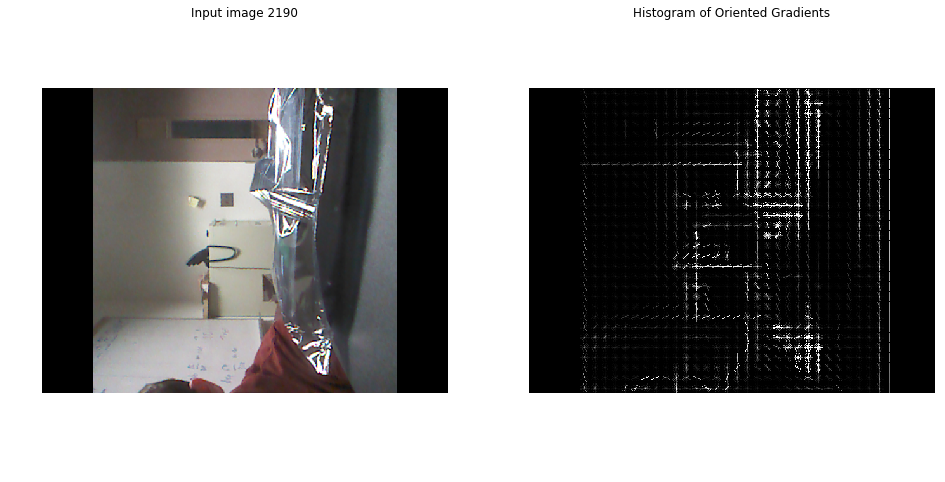

In [35]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, color, exposure


from freenect import sync_get_depth as get_depth, sync_get_video as get_video

(image_color,_) = get_video()

#image_color = cv2.imread(rgb_img[2190])#2190
image = color.rgb2gray(image_color)

rows,cols = image.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
rot = cv2.warpAffine(image,M,(cols,rows))



fd, hog_image = hog(rot, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)



#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)


rows,cols = image.shape

#M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
#rot = cv2.warpAffine(img,M,(cols,rows))

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

#hog_rot = cv2.warpAffine(hog_image_rescaled,M,(cols,rows))
rot = cv2.warpAffine(image_color,M,(cols,rows))

ax1.axis('off')
ax1.imshow(rot) #, cmap=plt.cm.gray)
ax1.set_title('Input image 2190')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()



In [ ]:
#from shutil import copy2

#for f in rgb_img:
#    fileName = f.split('/')[1]
#    fileName = fileName.split('.')[0]
#    dep_fileName = 'depth/' + fileName + '.pgm'
#    if np.random.random(1) < .8:
#        copy2(f,'rgb_train')
#        copy2(dep_fileName, 'depth_train')
#    else:
#        copy2(f,'rgb_test')
#        copy2(dep_fileName,'depth_test')

In [19]:
def getDepthTrain(f):
    fileName = f.split('/')[1]
    fileName = fileName.split('.')[0]
    dep_fileName = 'depth/' + fileName + '.pgm'
    return dep_fileName

In [14]:
test = getFiles('rgb_test')
print len(test)
test2 = getFiles('depth_test')
print len(test2)
train = getFiles('rgb_train')
print len(train)
train2 = getFiles('depth_train')
print len(train2)
print len(test) + len(train)
print test2

723
723
2676
2676
3399
['depth_test/seq0_0050_1.pgm', 'depth_test/seq0_0028_2.pgm', 'depth_test/seq0_0446_0.pgm', 'depth_test/seq0_0409_0.pgm', 'depth_test/seq0_0261_1.pgm', 'depth_test/seq0_0936_2.pgm', 'depth_test/seq0_0357_0.pgm', 'depth_test/seq0_0733_1.pgm', 'depth_test/seq0_0519_2.pgm', 'depth_test/seq0_0900_1.pgm', 'depth_test/seq0_1021_0.pgm', 'depth_test/seq0_0305_0.pgm', 'depth_test/seq0_1064_0.pgm', 'depth_test/seq0_0050_0.pgm', 'depth_test/seq0_0630_0.pgm', 'depth_test/seq0_0564_0.pgm', 'depth_test/seq0_1001_2.pgm', 'depth_test/seq0_0259_2.pgm', 'depth_test/seq0_0469_2.pgm', 'depth_test/seq0_0935_1.pgm', 'depth_test/seq0_0249_0.pgm', 'depth_test/seq0_0431_0.pgm', 'depth_test/seq0_0622_0.pgm', 'depth_test/seq0_0946_2.pgm', 'depth_test/seq0_0700_2.pgm', 'depth_test/seq0_0145_2.pgm', 'depth_test/seq0_0819_2.pgm', 'depth_test/seq0_0756_2.pgm', 'depth_test/seq0_0264_2.pgm', 'depth_test/seq0_0823_0.pgm', 'depth_test/seq0_0032_1.pgm', 'depth_test/seq0_0870_1.pgm', 'depth_test/seq0

In [15]:
from sklearn.model_selection import train_test_split
X = train
y = np.zeros(shape=(len(X)))
for i in range(0,len(X)):
    b = fileInDicts(X[i])
    if(b==True):
        y[i] = 1
    else:
        y[i] =-1
    
X_train, X_valid, y_train, y_valid = train_test_split( X, y,
        test_size=0.2)#, random_state=42)

#print X_test
#y_train
#X_test
print len(y_valid)



536


In [19]:
depth_img = cv2.imread(depth_file)
depth_img = depth_img[:,:,1]
print depth_img.shape
depth_resized = cv2.resize(depth_img, (96, 128)) 
depth_desc = hog.compute(depth_resized)

print(depth_desc.shape)

(480, 640)
(18900, 1)


In [20]:
from sklearn import svm

X_train_rgb = np.zeros(shape=(len(X_train),18900))
                       
X_train_depth = np.zeros(shape=(len(X_train),18900))
                         
clf_rgb_linear = svm.SVC(kernel='linear',probability=True)
clf_depth_linear = svm.SVC(kernel='linear',probability=True)
clf_rgb_rbf = svm.SVC(kernel='rbf',probability=True)
clf_depth_rbf = svm.SVC(kernel='rbf',probability=True)
                         
for i in range(0,len(X_train)):
    f = X_train[i]
    depth_file = getDepthTrain(f)
    #print f2
    rgb_img = cv2.imread(f)
    rgb_resized = cv2.resize(rgb_img, (96, 128)) 
    rgb_desc = hog.compute(rgb_resized)
    
    depth_img = cv2.imread(depth_file)
    depth_img = depth_img[:,:,1]
    depth_resized = cv2.resize(depth_img, (96, 128)) 
    depth_desc = hog.compute(depth_resized)
    #print(f)
    X_train_rgb[i] = rgb_desc.flatten()
    X_train_depth[i] = depth_desc.flatten() 
    
clf_rgb_linear.fit(X_train_rgb, y_train)
clf_rgb_rbf.fit(X_train_rgb, y_train)

clf_depth_linear.fit(X_train_depth, y_train)
clf_depth_rbf.fit(X_train_depth, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import GridSearchCV

#C_range = np.logspace(-2, 10, 13)
#gamma_range = np.logspace(-9, 3, 13)
#param_grid = dict(gamma=gamma_range, C=C_range)
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
#grid_rgb_rbf = GridSearchCV(svm.SVC(kernel='rbf', probability=True), param_grid=param_grid, cv=cv)
#grid_rgb_rbf.fit(X_train_rgb, y_train)

#grid_depth_rbf = GridSearchCV(svm.SVC(kernel='rbf', probability=True), param_grid=param_grid, cv=cv)
#grid_rgb_rbf.fit(X_train_depth, y_train)

In [21]:
rgb_rbf_false_pos = 0
rgb_rbf_false_neg = 0

dep_rbf_false_pos = 0
dep_rbf_false_neg = 0

rgb_linear_false_pos = 0
rgb_linear_false_neg = 0

dep_linear_false_pos = 0
dep_linear_false_neg = 0

predictors = [clf_rgb_linear, clf_rgb_rbf, clf_depth_linear, clf_depth_rbf]

y = y_valid
#from IPython.core.debugger import Tracer; Tracer()()
for i in range(0,len(X_valid)):

    f = X_valid[i]
    rgb_img = cv2.imread(f)
    rgb_resized = cv2.resize(rgb_img, (96, 128)) 
    rgb_desc = hog.compute(rgb_resized).flatten()
    
    depth_file = getDepthTrain(f)
    depth_img = cv2.imread(depth_file) 
    depth_resized = cv2.resize(depth_img, (96, 128)) 
    depth_desc = hog.compute(depth_resized).flatten()
    
    pred_rgb_linear =  clf_rgb_linear.predict(rgb_desc).flatten()
    pred_depth_linear =  clf_depth_linear.predict(depth_desc).flatten()
    pred_rgb_rbf = clf_rgb_rbf.predict(rgb_desc).flatten()
    pred_depth_rbf = clf_depth_rbf.predict(depth_desc).flatten()
    
    if((pred_rgb_rbf == -1) & (y[i] == 1)): rgb_rbf_false_neg+=1
    if((pred_rgb_rbf == 1) & (y[i] == -1)): rgb_rbf_false_pos+=1
        
    if((pred_rgb_linear == -1) & (y[i] == 1)): rgb_linear_false_neg+=1
    if((pred_rgb_linear == 1) & (y[i] == -1)): rgb_linear_false_pos+=1
        
    if((pred_depth_rbf == -1) & (y[i] == 1)): dep_rbf_false_neg+=1
    if((pred_depth_rbf == 1) & (y[i] == -1)): dep_rbf_false_pos+=1  
        
    if((pred_depth_linear == -1) & (y[i] == 1)): dep_linear_false_neg+=1
    if((pred_depth_linear == 1) & (y[i] == -1)): dep_linear_false_pos+=1   

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

In [ ]:
count = 0
for ys in y_valid:
    if(ys==1): count= count + 1

In [ ]:
print count

In [ ]:
print len(y_valid) - count

In [ ]:
k =  (7.0/4.)/((7./4.)+(4./7.))

In [22]:
print rgb_rbf_false_pos
print rgb_rbf_false_neg

print dep_rbf_false_pos
print dep_rbf_false_neg

print rgb_linear_false_pos
print rgb_linear_false_neg

print dep_linear_false_pos
print dep_linear_false_neg


171
0
70
31
3
6
8
13


In [ ]:
f = X_valid[10]
rgb_img = cv2.imread(f)
rgb_resized = cv2.resize(rgb_img, (96, 128)) 
rgb_desc = hog.compute(rgb_resized)

depthFile = getDepthTrain(f)
dep_img = cv2.imread(depthFile) 
dep_resized = cv2.resize(dep_img, (96, 128)) 
dep_desc = hog.compute(dep_resized)
a_rgb =  clf_rgb_rbf.predict_proba(rgb_desc.flatten())
a_depth =  clf_depth_rbf.predict_proba(dep_desc.flatten())
print a_rgb
print a_depth

In [ ]:
k = np.arange(0,1.02,.02)
print y_valid[10]

In [ ]:
print a_rgb.flatten()[1]

In [ ]:
k_val_linear = np.zeros(shape=k.shape)

In [23]:
def interpolateK(prob1, prob2, k):
    #prob1 = clf1.predict_proba(desc1.flatten())
    #prob2 = clf2.predict_proba(desc2.flatten())
    prob_mix = prob1 * k + (1.0-k) * prob2
    prob_mix = prob_mix.flatten()
    if prob_mix[0] > prob_mix[1]: return -1
    else: return 1

In [ ]:
#print k_val_linear
interpolateK(clf_rgb_linear,clf_depth_linear,1,rgb_desc,dep_desc)

In [25]:
k_arr = np.arange(0,1.005,.005)
k_val_linear = np.zeros(shape=k_arr.shape)
k_val_rbf = np.zeros(shape=k_arr.shape)
for i in range(0,len(X_valid)):
    f = X_valid[i]
    rgb_img = cv2.imread(f)
    rgb_resized = cv2.resize(rgb_img, (96, 128)) 
    rgb_desc = hog.compute(rgb_resized).flatten()
    
    depth_file = getDepthTrain(f)
    depth_img = cv2.imread(depth_file) 
    depth_resized = cv2.resize(depth_img, (96, 128)) 
    depth_desc = hog.compute(depth_resized).flatten()
    
    pred_rgb_rbf =  clf_rgb_rbf.predict_proba(rgb_desc.flatten()).flatten()
    pred_depth_rbf =  clf_depth_rbf.predict_proba(depth_desc.flatten()).flatten()
    
    pred_rgb_linear = clf_rgb_linear.predict_proba(rgb_desc).flatten()
    pred_depth_linear = clf_depth_linear.predict_proba(depth_desc).flatten()
    
    for j in range(0,len(k_arr)):
        k = k_arr[j]
        guess_linear = interpolateK(pred_rgb_linear,pred_depth_linear,k)
        guess_rbf = interpolateK(pred_rgb_rbf,pred_depth_rbf,k)
        if(guess_rbf != y_valid[i]):
            k_val_rbf[j] = k_val_rbf[j]+1.0
        if(guess_linear != y_valid[i]):
            k_val_linear[j] = k_val_linear[j]+1.0

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

In [32]:
rbf_k = .1
linear_k = .6

rgb_rbf_miss = 0
dep_rbf_miss = 0
mix_rbf_miss = 0

rgb_linear_miss = 0
dep_linear_miss = 0
mix_linear_miss = 0

test_labels = np.zeros(len(test))
for i in range(0,len(test)):
    if(fileInDicts(test[i])):
        test_labels[i] = 1
    else:
        test_labels[i] = -1


for i in range(0,len(test)):
    f = test[i]
    rgb_img = cv2.imread(f)
    rgb_resized = cv2.resize(rgb_img, (96, 128)) 
    rgb_desc = hog.compute(rgb_resized).flatten()
    
    depth_file = getDepthTrain(f)
    depth_img = cv2.imread(depth_file) 
    depth_resized = cv2.resize(depth_img, (96, 128)) 
    depth_desc = hog.compute(depth_resized).flatten()
    
    pred_rgb_rbf =  clf_rgb_rbf.predict_proba(rgb_desc.flatten()).flatten()
    pred_depth_rbf =  clf_depth_rbf.predict_proba(depth_desc.flatten()).flatten()
    pred_rgb_linear =  clf_rgb_linear.predict_proba(rgb_desc.flatten()).flatten()
    pred_depth_linear = clf_depth_rbf.predict_proba(depth_desc.flatten()).flatten()
    
    rgb_rbf = interpolateK(pred_rgb_rbf, pred_depth_rbf, 1)
    dep_rbf = interpolateK(pred_rgb_rbf, pred_depth_rbf, 0)
    mix_rbf = interpolateK(pred_rgb_rbf, pred_depth_rbf, rbf_k)
    
    rgb_linear = interpolateK(pred_rgb_linear, pred_depth_linear, 1)
    dep_linear = interpolateK(pred_rgb_linear, pred_depth_linear, 0)
    mix_linear = interpolateK(pred_rgb_linear, pred_depth_linear, linear_k)
    
    if(rgb_rbf != test_labels[i]): rgb_rbf_miss+=1
    if(dep_rbf != test_labels[i]): dep_rbf_miss+=1
    if(mix_rbf != test_labels[i]): mix_rbf_miss+=1
    if(rgb_linear != test_labels[i]): rgb_linear_miss+=1
    if(rgb_linear != test_labels[i]): dep_linear_miss+=1
    if(rgb_linear != test_labels[i]): mix_linear_miss+=1
    
    

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

0.605
6.0


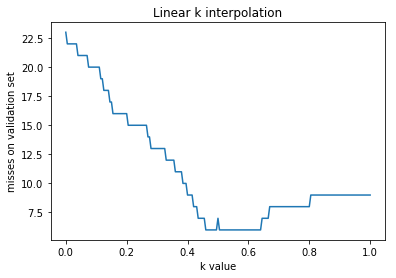

In [26]:
print k_arr[121]
print k_val_linear[121]
import matplotlib.pyplot as pyplot
pyplot.plot(k_arr,k_val_linear)
pyplot.title('Linear k interpolation')
pyplot.ylabel('misses on validation set')
pyplot.xlabel('k value')

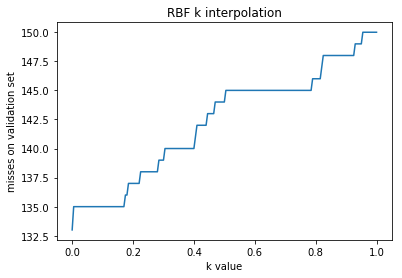

In [27]:
import matplotlib.pyplot as pyplot
pyplot.plot(k_arr,k_val_rbf)
pyplot.title('RBF k interpolation')
pyplot.ylabel('misses on validation set')
pyplot.xlabel('k value')

In [34]:
print rgb_rbf_miss
print dep_rbf_miss
print mix_rbf_miss

print rgb_linear_miss
print dep_linear_miss
print mix_linear_miss

print len(test)

168
159
159
13
13
13
723


In [98]:
def mixImage(f):
    rgb_file = f
    rgb_img = cv2.imread(rgb_file)
    rgb_resized = cv2.resize(rgb_img, (96, 128))

    dep_file = getDepthTrain(rgb_file)
    dep_img = cv2.imread(dep_file)
    dep_resized = cv2.resize(dep_img, (96, 128))

    mix_img = np.zeros((128,96,4))
    mix_img[:,:,0:3]= rgb_resized
    mix_img[:,:,3]= dep_resized[:,:,1]
    if(fileInDicts(f)): y = 1
    else: y = -1
    return (mix_img, y)

In [140]:
import cv2

mix_imgs = []
ys = []
X_train_all = X_train+X_valid
for i in range(150,1150):#len(X_train_all)):
    
    mix_img, y = mixImage(X_train[i])
    if y == 1:
        mix_imgs.append(mix_img)
        ys.append(np.array([0,1]))
    else:
        for j in range(0,1):
            mix_imgs.append(mix_img)
            ys.append(np.array([1,0]))

In [23]:
f = open('train_valid_test.txt')
text = f.read()
lines = text.splitlines()

for i in range(0, len(lines)):
    if(lines[i]=='Train'):print i
    if(lines[i]=='Valid'):print i
    if(lines[i]=='Test'):print i  
X_train = lines[1:2176]
X_valid = lines[2177:2721]
X_test = lines[2722::]
X = X_train
y = np.zeros(shape=(len(X)))
for i in range(0,len(X)):
    b = fileInDicts(X[i])
    if(b==True):
        y[i] = 1
    else:
        y[i] =-1
y_train = y
X = X_valid
y = np.zeros(shape=(len(X)))
for i in range(0,len(X)):
    b = fileInDicts(X[i])
    if(b==True):
        y[i] = 1
    else:
        y[i] =-1
y_valid = y
X = X_test
y = np.zeros(shape=(len(X)))
for i in range(0,len(X)):
    b = fileInDicts(X[i])
    if(b==True):
        y[i] = 1
    else:
        y[i] =-1
y_test = y

0
2176
2721


In [141]:
x_train = np.array(mix_imgs)
y_train = np.array(ys)
count = 0
for y in ys:
    if(y[0]==1):count+=1
print count
print len(ys)

305
1000


In [143]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=x_train[0].shape))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=1e-5, momentum=0.9)
#model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=64, epochs=15)
#score = model.evaluate(x_test, y_test, batch_size=32)

Epoch 1/15
1000/1000 [==============================] - 178s - loss: 0.3485 - acc: 0.5090     

KeyboardInterrupt: 

In [54]:
json_string = model.to_json()
#print json_string
f = open("model.json",'w')
f.write(json_string)
f.close()

In [99]:

#print X_test[5]\
false_neg = 0
false_pos = 0

for i in range(0,len(X_test)):
    (x_m,y_m) = mixImage(X_test[i])
    x_m = x_m.reshape(1,128,96,4)
    y_p = model.predict(x_m)
    print str(i) + ' actual ' +str(y_m)
    print 'predicted ' + str(y_p)


0 actual -1
predicted [[ 0.  1.]]
1 actual 1
predicted [[ 0.  1.]]
2 actual 1
predicted [[ 0.  1.]]
3 actual 1
predicted [[ 0.  1.]]
4 actual -1
predicted [[ 0.  1.]]
5 actual 1
predicted [[ 0.  1.]]
6 actual 1
predicted [[ 0.  1.]]
7 actual 1
predicted [[ 0.  1.]]
8 actual 1
predicted [[ 0.  1.]]
9 actual 1
predicted [[ 0.  1.]]
10 actual 1
predicted [[ 0.  1.]]
11 actual -1
predicted [[ 0.  1.]]
12 actual 1
predicted [[ 0.  1.]]
13 actual -1
predicted [[ 0.  1.]]
14 actual -1
predicted [[ 0.  1.]]
15 actual -1
predicted [[ 0.  1.]]
16 actual 1
predicted [[ 0.  1.]]
17 actual 1
predicted [[ 0.  1.]]
18 actual 1
predicted [[ 0.  1.]]
19 actual -1
predicted [[ 0.  1.]]
20 actual 1
predicted [[ 0.  1.]]
21 actual -1
predicted [[ 0.  1.]]
22 actual 1
predicted [[ 0.  1.]]
23 actual 1
predicted [[ 0.  1.]]
24 actual 1
predicted [[ 0.  1.]]
25 actual -1
predicted [[ 0.  1.]]
26 actual 1
predicted [[ 0.  1.]]
27 actual 1
predicted [[ 0.  1.]]
28 actual -1
predicted [[ 0.  1.]]
29 actual 1
pr

[[ 0.  1.]]


In [96]:
print y_train[10]
print mix_imgs[10].shape
x2,_ = mixImage(X_train[10])
print mix_imgs[10] == x2
print x2.shape
x3 = x2.reshape((1,) + x2.shape)
model.predict(x3)

[ 1.  0.]
(128, 96, 4)
[[[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ..., 
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ..., 
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ..., 
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 ..., 
 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ..., 
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ..., 
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  Tr

array([[ 0.,  1.]], dtype=float32)